In [2]:
# ! pip install pixell --quiet
! pip install --upgrade numpy --quiet

In [3]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import math
from pixell import enmap, enplot, reproject 
from astropy.io import ascii, fits
from PIL import Image
import astropy.coordinates as coord
import astropy.table as atpy
import astropy.units as u
import plotly
import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import cv2 as cv
import random 
import os

In [4]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Объявляем пути до необходимых файлов

In [5]:
maps_path = "drive/MyDrive/ACT"
path90 = os.path.join(maps_path, "act_dr5_f90.fits")
path150 = os.path.join(maps_path, "act_dr5_f150.fits")
path220 = os.path.join(maps_path, "act_dr5_f220.fits")
cluster_catalog = os.path.join(maps_path, "cluster-catalog.fits")

Функция для чтения части всех карт 

In [6]:
def read_maps_box(ra_dp, dec_dp):
    ra_from, ra_to = np.deg2rad(ra_dp)
    dec_from, dec_to = np.deg2rad(dec_dp)
    box = [[dec_from,ra_from],[dec_to,ra_to]]
    imap90 = enmap.read_map(path90, box=box)
    imap150 = enmap.read_map(path150, box=box)
    imap220 = enmap.read_map(path220, box=box)
    return imap90, imap150, imap220

In [7]:
def read_map_full(path):
    return enmap.read_map(path)

In [8]:
# imap90, imap150, imap220 = read_maps_box([50, 160], [-30, 20])

In [ ]:
imap = read_map_full(path90)

In [10]:
tab = atpy.Table().read(cluster_catalog)

Представляем каталог кластеров как pandas DataFrame

In [11]:
df = pd.DataFrame(dict(
    ra = list(tab['RADeg']),
    dec = list(tab['decDeg']),
    m500 = list(tab['M500c']),
    z = list(tab['redshift']),
    snr = list(tab['SNR']),
    y_coord = [0.0] * len(tab),
    x_coord = [0.0] * len(tab)
))

Выбираем только видимые галактики и вычисляем их координаты на карте

In [12]:
work_glx = df.loc[(df['snr'] > 8.5)]
for ind, glx in work_glx.iterrows():
    dec = glx['dec']
    ra = glx['ra']
    coords = np.deg2rad(np.array((dec,ra)))
    work_glx.at[ind, 'y_coord'], work_glx.at[ind, 'x_coord'] = enmap.sky2pix(imap.shape, imap.wcs, coords)

In [13]:
def normalize(img):
    min_val = np.min(img)
    if min_val > 0:
        img -= min_val
    else:
        img += abs(min_val)
    img /= np.max(img)
    img *= 255
    img = img.astype('uint8')
    return img

In [14]:
def auto_contrast(img, norm=True):
    diff = abs(np.max(img) - np.min(img))
    if norm:
        img = normalize(img)
    alpha = max(1., 2/2200 * diff + 9/29)
    return cv.convertScaleAbs(img, alpha=alpha)

Функция для вывода только одного кластера

In [14]:
def show_patch(fmap, id, width=1, fsize=6, cmap='viridis'):
    fig, axs = plt.subplots(1, 1, figsize=(fsize, fsize))    
    ra, dec = df['ra'].iloc[id], df['dec'].iloc[id]
    box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
    res = fmap[0].submap(box)
    # print(np.min(res), np.max(res), abs(np.max(res) - np.min(res)))
    # res = auto_contrast(res)
    axs.set_xlabel("m500={}, SNR={}".format(df.loc[id]['m500'], 
                                            df.loc[id]['snr']))
    axs.imshow(res, cmap=cmap)

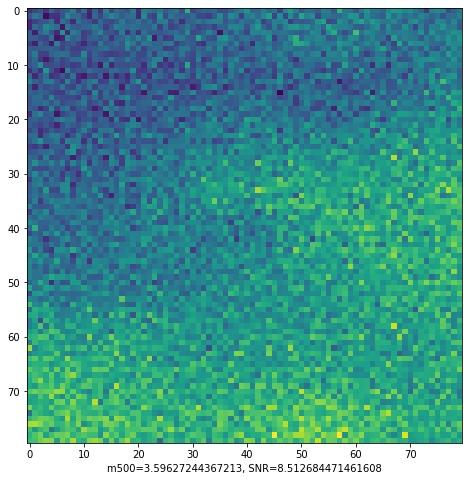

In [89]:
show_patch(imap, 1007, width=40/60, fsize=8)

Функция для вывода нескольких кластеров в разной ориентации (вертикальной/горизантальной)

In [15]:
def show_patches(fmap, glxs, is_vertical=True, width=1, cmap='viridis', fsize=15):
    if len(glxs) == 1:
        show_patch(fmap, glxs[0], width=width, cmap=cmap, fsize=fsize)
    else:
        if is_vertical:
            fig, axs = plt.subplots(len(glxs), 1, figsize=(fsize, fsize))    
        else:
            fig, axs = plt.subplots(1, len(glxs), figsize=(fsize, fsize))    
        for i, id in enumerate(glxs):
            fig.tight_layout(pad=4)
            ra, dec = df['ra'].iloc[id], df['dec'].iloc[id]
            box = np.deg2rad([[dec-width/2.,ra-width/2.], 
                              [dec+width/2.,ra+width/2.]])
            res = fmap[0].submap(box)
            res = auto_contrast(res)
            axs[i].set_xlabel("m500={}, SNR={}, z={}".format(
                round(df.loc[id]['m500'], 4),
                round(df.loc[id]['snr'], 4), 
                round(df.loc[id]['z'], 4)))
            axs[i].imshow(res, cmap=cmap)

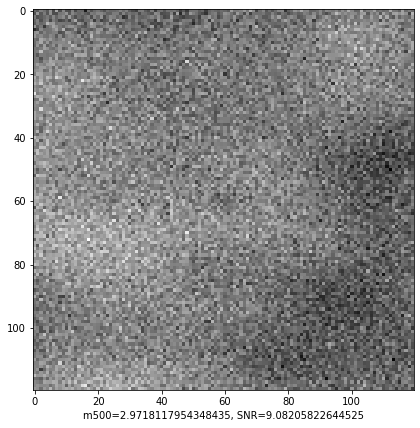

In [76]:
show_patches(imap, [724], is_vertical=False, fsize=7, cmap='gray')

In [150]:
def show_freq_patches(maps, freqs, glxs, width=1, fsize=20, cmap="viridis"):
    fig, axs = plt.subplots(len(glxs), len(freqs), figsize=(fsize, fsize))    
    for i, id in enumerate(glxs):
        fig.tight_layout(pad=7)
        ra, dec = df['ra'].iloc[id], df['dec'].iloc[id]
        box = np.deg2rad([[dec-width/2.,ra-width/2.],[dec+width/2.,ra+width/2.]])
        for j, imap, freq in enumerate(zip(freqs)):
            axs[i][j].set_title('Frequency {}'.format(freq[i]))
            axs[i][j].set_xlabel("m500={}, SNR={}".format(df.loc[id]['m500'], 
                                                          df.loc[id]['snr']),
                                                          fontsize=10)
            res = imap[0].submap(box)
            res = auto_contrast(res)
            axs[i][j].imshow(res, cmap=cmap)

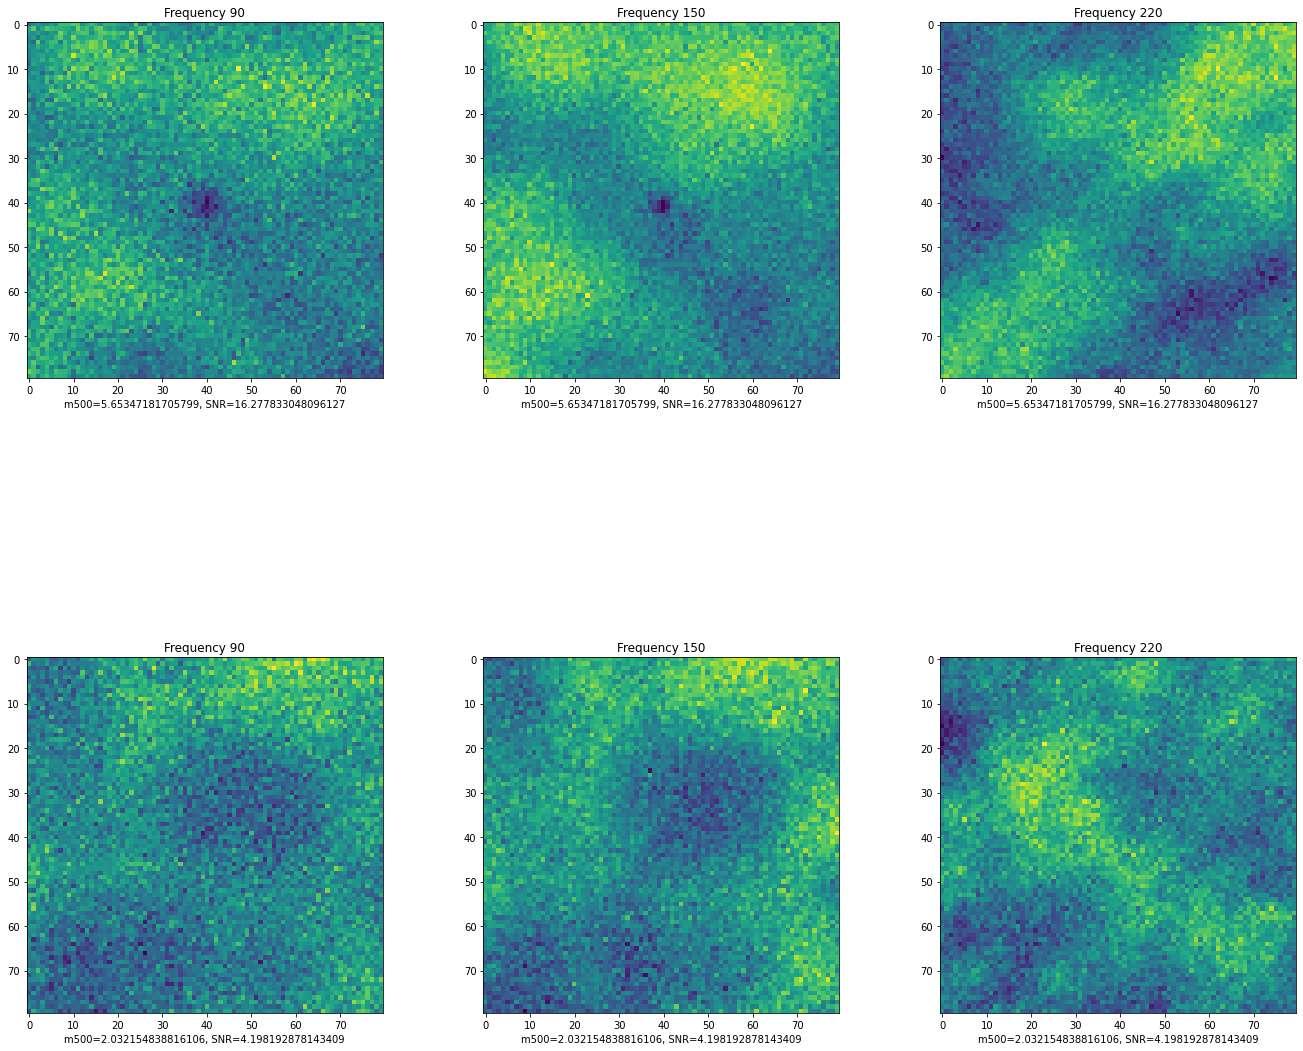

In [ ]:
show_freq_patches([2091, 2079], width=40/60)

Функция для генерации патчей(как просто картинок, так и масок сегментации)

In [15]:
def glx_in_box(glxs, curr_h, curr_w, box_height, box_width):
    return glxs.loc[(glxs['y_coord'] > curr_h)
             & (glxs['y_coord'] < curr_h + box_height)
             & (glxs['x_coord'] > curr_w)
             & (glxs['x_coord'] < curr_w + box_width)]

In [18]:
def make_mask(row, curr_w, curr_h, coef, bias):
    x, y = row['x_coord'], row['y_coord']
    res = np.zeros((100, 100), dtype='uint8')
    radius = min(max(row['m500'] * coef + bias, 1), 5)
    cv.circle(res, (math.floor(x) - curr_w, math.floor(y) - curr_h), 
              round(radius), (255, 255, 255), thickness=-1, lineType=-1)
    return res

In [19]:
def make_color(res):
    res = auto_contrast(res)
    viridis = plt.cm.get_cmap('viridis')
    res = viridis(res) * 255
    return res[:, :, :3]

In [22]:
def make_patches(imap, glxs, path, mask=False):
    box_size = 100
    coef = 0.32456
    bias = 1.46572561
    curr_h, curr_w, start_h, start_w = 0, 0, 0, 0
    img_counter = 0
    if not os.path.exists(os.path.join(maps_path, path)):
        os.makedirs(os.path.join(maps_path, path))
    while (curr_h < imap.shape[1]):
        curr_w = start_w
        while (curr_w < imap.shape[2]):
            tmp = glx_in_box(glxs, curr_h, curr_w, box_size, box_size)
            if len(tmp) > 0:
                for ind, row in tmp.iterrows():
                    img_counter += 1
                    if mask:
                        res = make_mask(row, curr_w, curr_h, coef, bias)
                    else:
                        res = imap[0][curr_h:curr_h+box_size, curr_w:curr_w + box_size].copy()
                        res = make_color(res)
                    result = Image.fromarray(res.astype('uint8'))
                    result.save(os.path.join(maps_path, path, 
                                '{}_id_{}_90_fq.png'.format(img_counter, ind)))
            curr_w += 80
        curr_h += 80

In [23]:
make_patches(imap, work_glx, 'dataset', mask=False)